In [20]:
root = '../'

import os, sys
from skimage import io, transform
import numpy as np
from pathlib import Path
from PIL import Image
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import mask_rcnn
from torch.optim import SGD
from torch.utils.tensorboard import SummaryWriter

In [21]:
# Basic settings
from easydict import EasyDict as edict

cfg = []

torch.manual_seed(470)
torch.cuda.manual_seed(470)

BB_TYPES = [
    'title',
    'header',
    'text box',
    'footer',
    'picture',
    'instructor',
    'diagram',
    'table',
    'figure',
    'handwriting',
    'chart',
    'schematic diagram',
]

args = edict()
args.batch_size = 1
args.lr = 1e-4
args.momentum = 0.9
args.weight_decay = 5e-4
args.epoch = 10
args.tensorboard = False
args.gpu = True
args.train_portion = 0.7
args.slide_deck_embedding_dim = 128
args.bbtype_num = len(BB_TYPES)
args.latent_dim = 32
args.hidden_size = 64
args.input_size = 64 
args.dropout_rate = 0.5

assert(args.latent_dim == args.input_size//2)

device = 'cuda' if torch.cuda.is_available() and args.gpu else 'cpu'

# Create directory name.
result_dir = Path(root) / 'results'
result_dir.mkdir(parents=True, exist_ok=True)

In [22]:
if args.tensorboard:
    %load_ext tensorboard
    %tensorboard --logdir "{str(result_dir)}" --samples_per_plugin images=100

In [23]:
def draw_image(image, bbs):
    if (torch.is_tensor(image)):
        image = np.array(image.tolist()).transpose((1, 2, 0))
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())

    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

class FitVidDataset(Dataset):
    """ FitVid Dataset"""
    
    def __init__(self, img_data, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.img_data = img_data
        self.img_filenames = list(self.img_data.keys())
    
    def __len__(self):
        return len(self.img_filenames)

    def show_image(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = self.img_filenames[idx]
        img_dir = os.path.join(self.root_dir, filename)
        
        image = io.imread(img_dir)
        draw_image(image, self.img_data[filename]['bbs'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        filename = self.img_filenames[idx]
        img_dir = os.path.join(self.root_dir, filename)
        image = io.imread(img_dir)

        bbs = self.img_data[filename]['bbs']

        sample = {
            'image' : image,
            'labels' : bbs,
        }
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [24]:
def draw_bbs(shape, bbs):
    if (torch.is_tensor(bbs)):
        bbs = np.array(bbs.tolist())
    if (torch.is_tensor(shape)):
        [h, w] = np.array(shape.tolist())
        shape = (h, w)
    
    h, w = shape
    fig, ax = plt.subplots(1)
    background=patches.Rectangle((0, 0), w, h, linewidth=2, edgecolor='b', facecolor='black')
    ax.add_patch(background)
    for bb in bbs:
        rect = patches.Rectangle((bb[0], bb[1]), bb[2], bb[3], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.autoscale(True, 'both')
    plt.show()
    return

def get_BB_types(bbs):
    return bbs[:, 4]

class BBSlideDeckDataset(Dataset):
    """ Slide Deck Dataset but with Bounding Boxes"""
    def __init__(self, slide_deck_data, transform=None):
        self.transform = transform

        self.slide_deck_data = slide_deck_data
        self.slide_deck_ids = list(self.slide_deck_data.keys())
    
    def __len__(self):
        return len(self.slide_deck_ids)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        slide_deck_id = self.slide_deck_ids[idx]
        (h, w) = self.slide_deck_data[slide_deck_id]["shape"]
        lengths_slide_deck = []
        slides = []
        max_len_bbs = 0
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            lengths_slide_deck.append(len(slide))
            if len(slide) > max_len_bbs:
                max_len_bbs = len(slide)
        for slide in self.slide_deck_data[slide_deck_id]["slides"]:
            np_slide = np.zeros((max_len_bbs, 5))
            for i, bb in enumerate(slide):
                np_slide[i] = bb
            slides.append(np_slide)

        ref_slide = slides[0]
        slide_deck = slides[1:]
        length_ref_types = lengths_slide_deck.pop(0)
        sample = {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": get_BB_types(ref_slide),
            "slide_deck": np.asarray(slide_deck),
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

        if self.transform:
            sample = self.transform(sample)
        return sample


In [25]:
class RescaleBB(object):
    """Rescale the bounding boxes in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def _resize_single_slide(self, slide, original_shape, new_shape):
        h, w = original_shape
        new_h, new_w = new_shape
        slide = slide * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return slide

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        ref_slide = self._resize_single_slide(ref_slide, (h, w), (new_h, new_w))
        for i, slide in enumerate(slide_deck):
            slide_deck[i] = self._resize_single_slide(slide, (h, w), (new_h, new_w))

        return {
            "shape": (new_h, new_w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class LeaveN(object):
    def __init__ (self, N):
        self.N = N

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        if slide_deck.shape[0] > self.N:
            slide_deck = np.delete(slide_deck, range(self.N, slide_deck.shape[0]), 0)
            lengths_slide_deck = lengths_slide_deck[:self.N]

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ShuffleRefSlide(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]

        lengths_slide_deck.append(length_ref_types)
        slide_deck = np.vstack((slide_deck, ref_slide[None, :]))

        idxs = np.array([*range(0, len(lengths_slide_deck))], dtype=np.int32)
        np.random.shuffle(idxs)

        slide_deck = slide_deck[idxs]

        lengths_slide_deck = np.array(lengths_slide_deck)
        lengths_slide_deck = lengths_slide_deck[idxs]
        lengths_slide_deck = lengths_slide_deck.tolist()
        
        slide_deck = slide_deck.tolist()
        ref_slide = np.asarray(slide_deck.pop())
        length_ref_types = lengths_slide_deck.pop()
        ref_types = get_BB_types(ref_slide)

        slide_deck = np.asarray(slide_deck)
        
        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "ref_types": ref_types,
            "slide_deck": slide_deck,
            "lengths_slide_deck": lengths_slide_deck,
            "length_ref_types": length_ref_types,
        }

class ToTensorBB(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        ref_types = sample["ref_types"]
        slide_deck = sample["slide_deck"]
        lengths_slide_deck = sample["lengths_slide_deck"]
        length_ref_types = sample["length_ref_types"]
        return {
            "shape": torch.tensor([h, w]),
            "ref_slide": torch.from_numpy(ref_slide),
            "ref_types": torch.from_numpy(ref_types),
            "slide_deck": torch.from_numpy(slide_deck),
            "lengths_slide_deck": torch.tensor(lengths_slide_deck),
            "length_ref_types": torch.tensor(length_ref_types)
        }

In [26]:
class RescaleBB(object):
    """Rescale the bounding boxes in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def _resize_single_slide(self, slide, original_shape, new_shape):
        h, w = original_shape
        new_h, new_w = new_shape
        slide = slide * np.array([new_w / w, new_h / h, new_w / w, new_h / h, 1]).T
        return slide

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        slide_deck = sample["slide_deck"]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        ref_slide = self._resize_single_slide(ref_slide, (h, w), (new_h, new_w))
        for i, slide in enumerate(slide_deck):
            slide_deck[i] = self._resize_single_slide(slide, (h, w), (new_h, new_w))

        return {
            "shape": (new_h, new_w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class LeaveN(object):
    def __init__ (self, N):
        self.N = N

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        slide_deck = sample["slide_deck"]

        np.random.shuffle(slide_deck)

        if slide_deck.shape[0] > self.N:
            slide_deck = np.delete(slide_deck, range(self.N, slide_deck.shape[0]), 0)

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class ShuffleRefSlide(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        slide_deck = sample["slide_deck"]
        
        slide_deck = np.vstack((slide_deck, ref_slide[None, :]))
        np.random.shuffle(slide_deck)
        slide_deck = slide_deck.tolist()
        ref_slide = np.asarray(slide_deck.pop())
        slide_deck = np.asarray(slide_deck)

        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class ShuffleSlideDeck(object):
    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample['ref_slide']
        slide_deck = sample["slide_deck"]
        np.random.shuffle(slide_deck)
        
        return {
            "shape": (h, w),
            "ref_slide": ref_slide,
            "slide_deck": slide_deck
        }

class ToTensorBB(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        h, w = sample["shape"]
        ref_slide = sample["ref_slide"]
        slide_deck = sample["slide_deck"]
        return {
            'shape': torch.tensor([h, w]),
            'ref_slide': torch.from_numpy(ref_slide),
            'slide_deck': torch.from_numpy(slide_deck)
        }

In [27]:
def process_slide_deck_dataset(all_dataset):
    slide_deck_data = {}
    for entrance in all_dataset.iloc:
        slide_deck_id = entrance['Slide Deck Id']
        
        slide_id = entrance["Slide Id"]
        if (slide_deck_id not in slide_deck_data):
            slide_deck_data[slide_deck_id] = {
                'slides': {},
                'shape': (entrance['Image Height'], entrance['Image Width'])
            }
        
        if slide_id not in slide_deck_data[slide_deck_id]["slides"]:
            slide_deck_data[slide_deck_id]["slides"][slide_id] = []
        bb_type = BB_TYPES.index(entrance['Type'])
        if (bb_type < 0 or bb_type >= len(BB_TYPES)):
            bb_type = len(BB_TYPES)

        bb = np.array([
            entrance['X'],
            entrance['Y'],
            entrance['BB Width'],
            entrance['BB Height'],
            bb_type + 1
        ]).T
        slide_deck_data[slide_deck_id]['slides'][slide_id].append(bb)
    for key in slide_deck_data.keys():
        
        # if key == 100:
        #     for (id, value) in slide_deck_data[key]["slides"].items():
        #         print(56, id)
        #         draw_bbs(slide_deck_data[key]["shape"], value)

        values = list(slide_deck_data[key]["slides"].values())
        slide_deck_data[key]["slides"] = [np.asarray(value) for value in values]
    return slide_deck_data

def slice_dict(dictionary, l, r):
    keys = list(dictionary.keys())
    keys = keys[l:r]
    ret_dictionary = {}
    for key in keys:
        ret_dictionary[key] = dictionary[key]
    return ret_dictionary

In [28]:
csv_file = os.path.join(os.path.dirname(os.getcwd()), "data", "slide_deck_dataset.csv")

dataset = pd.read_csv(csv_file)
slide_deck_data = process_slide_deck_dataset(dataset)

division = int(args.train_portion * len(slide_deck_data))

train_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, 0, division),
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        ShuffleRefSlide(),
        ShuffleSlideDeck(),
        LeaveN(5),
        ToTensorBB()
    ])
)

test_slide_deck_dataset = BBSlideDeckDataset(
    slide_deck_data=slice_dict(slide_deck_data, division, len(slide_deck_data)),
    transform=transforms.Compose([
        RescaleBB((1, 1)),
        #ShuffleSlideDeck(),
        #ShuffleRefSlide(),
        #LeaveN(5),
        ToTensorBB()
    ])
)


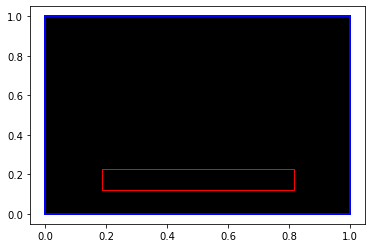

torch.Size([7, 5]) torch.Size([5, 7, 5])
____________
shape
torch.Size([2])
____________
ref_slide
torch.Size([7, 5])
____________
slide_deck
torch.Size([5, 7, 5])


In [37]:
single = train_slide_deck_dataset[0]
draw_bbs(single["shape"], single["ref_slide"])
print(single["ref_slide"].shape, single["slide_deck"].shape)
for key, sl in single.items():
    print("____________")
    print(key)
    print(sl.shape)

In [30]:
def to_one_hot(y, n_dims=None):
    """ Take integer y (tensor or variable) with n dims and convert it to 1-hot representation with n+1 dims. """
    y_tensor = y.data if isinstance(y, torch.autograd.Variable) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y.shape, -1)
    return torch.autograd.Variable(y_one_hot) if isinstance(y, torch.autograd.Variable) else y_one_hot

class Decoder(nn.Module):
    def __init__(self, embedding=False):
        super(Decoder, self).__init__()
        self.exist_embedding = embedding
        if self.exist_embedding:
            self.embed = nn.Embedding(args.bbtype_num + 1, args.input_size//2, padding_idx=0)
            input_size = args.input_size
        else:
            input_size = args.input_size//2 + args.bbtype_num + 1
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=args.hidden_size, num_layers=2, 
            batch_first=True, dropout=args.dropout_rate, bias=True)
        self.linear1 = nn.Linear(args.slide_deck_embedding_dim, args.hidden_size)
        self.linear2 = nn.Linear(args.hidden_size, 4)


    def forward(self, x, z, slide_deck_embedding, length=None):
        """

        Args:
            x (tensor): bb labels, (Batch_size, Sequence_size)
            z (tensor): latent vector, (Batch_size, latent_vector_dim)
            slide_deck_embedding (tensor): slide_deck_embedding vector, (Batch_size, slide_deck_embedding_dim)
            length (tensor): (Batch_size,)

        Returns:
            bb sequence: (tensor), (Batch_size, Sequence_size, 5)
        """
        (Batch_size, Sequence_size) = x.shape
        if self.exist_embedding:
            temp_input_1 = self.dropout(self.embed(x))   # Batch_size, Sequence_size, input_size
        else:
            temp_input_1 = to_one_hot(x, n_dims=args.bbtype_num + 1)
            temp_input_1[:, :, 0] = 0.0
            temp_input_1 = temp_input_1.to(device)

                
        temp_input_2 = z.unsqueeze(1).repeat((1, Sequence_size, 1))
        input_1 = torch.cat((temp_input_2, temp_input_1), dim=-1)
        hidden_0 = self.dropout(self.linear1(slide_deck_embedding)).unsqueeze(0).repeat((2, 1, 1))
        c_0 = torch.zeros(size=(2,Batch_size, args.hidden_size)).to(device)
        output, (h_n, c_n) = self.lstm(input_1, (hidden_0, c_0))
        output = output.transpose(0, 1)
        return self.linear2(output)

In [31]:
embedding = nn.Embedding(10, 3, padding_idx=0)
input = torch.LongTensor([[0,2,4,0],[4,3,0,0]])
embedding(input).shape

a = to_one_hot(input)
a[:,:,0] = 0
a.shape

torch.Size([2, 4, 5])

In [32]:
rnn = nn.LSTM(10, 20, 2) #input_size  = 10, hidden = 20, layer=2
input = torch.randn(5, 3, 10) # 3 batch, 
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [33]:
output.shape, hn.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

In [34]:
x = torch.tensor([[2, 3,2],[23,2, 2]])
print(x.shape)
x.unsqueeze(1).repeat((1,2,1))


torch.Size([2, 3])


tensor([[[ 2,  3,  2],
         [ 2,  3,  2]],

        [[23,  2,  2],
         [23,  2,  2]]])